# Case Study on Event Logging.

##  Background

*Event logging* (EL) is used to track a variety of performance and usage metrics to help on the decision making process. Specifically, the most used metrics are:

- *clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed
- *zero results rate*: the proportion of searches that yielded 0 results

Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that it is used to estimate how long users stay on the pages they visit. The dataset contains just a little more than a week of EL data.

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

# Importing Libraries and Reading Data

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from datetime import datetime as dt

In [103]:
data = pd.read_csv("events_log.csv.gz",parse_dates=['timestamp'])

In [104]:
data.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,20160301103842,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,20160307005226,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,20160302145305,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,20160302222701,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,20160302095023,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             400165 non-null  object 
 1   timestamp        400165 non-null  object 
 2   session_id       400165 non-null  object 
 3   group            400165 non-null  object 
 4   action           400165 non-null  object 
 5   checkin          223824 non-null  float64
 6   page_id          400165 non-null  object 
 7   n_results        136234 non-null  float64
 8   result_position  230482 non-null  float64
dtypes: float64(3), object(6)
memory usage: 27.5+ MB


In [106]:
data.describe()

,checkin,n_results,result_position
count,223824.000000,136234.000000,230482.000000
mean,97.190382,13.210109,2.992798
std,104.593714,13.271104,38.557292
min,10.000000,0.000000,1.000000
25%,20.000000,2.000000,1.000000
50%,50.000000,20.000000,1.000000
75%,150.000000,20.000000,2.000000
max,420.000000,500.000000,4103.000000


In [107]:
#check for NaN values
data.isnull().sum()

uuid                    0
timestamp               0
session_id              0
group                   0
action                  0
checkin            176341
page_id                 0
n_results          263931
result_position    169683
dtype: int64

In [108]:
#check if there are duplicte rows
data.duplicated(subset=None, keep='first').any()

False

## Feature Engineering 

In [109]:
#convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'],errors='coerce')

In [110]:
data[data.timestamp.isna()]

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
40952,1a5b663f6a1258f588dc4de65c90b5c0,NaT,35a29e7a78ccc24b,a,checkin,180.0,8f0d489715dd14b0,NaN,NaN
157636,6509e446fe7852fbb503af7d3453c6df,NaT,aa89be8089ff5694,a,checkin,420.0,2ba84fc2f11fbc92,NaN,1.0
221506,8d8ffe3bfba4516f9d0d8c1decbe1b76,NaT,13cd6d70d0fa2b58,a,checkin,120.0,041d0e94cde215fd,NaN,1.0
348288,deac7c11f00d598292f9e18ee2f6997f,NaT,426b242692d66473,a,searchResultPage,NaN,2ab3d9ca41b16173,20.0,NaN


In [111]:
#as there are just 4 rows that were affected, dropping them will not impact the analysis, thus, dropping them
data = data.dropna(subset=['timestamp'])

In [112]:
#add new columns
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

In [113]:
#confirms the dataset has 1 year -> 2016
data['year'].nunique()

1

In [114]:
#confirms the dataset has 1 month -> 03
data['month'].nunique()

1

In [115]:
data['day'].nunique()

8

In [116]:
data['day'].unique()

array([1, 7, 2, 3, 5, 8, 6, 4], dtype=int64)

In [117]:
data['group'].unique()

array(['b', 'a'], dtype=object)

# 1. What is the daily overall clickthrough rate? How does it vary between the groups?

#### Overall CTR

In [118]:
#Day 01
CTR_01 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 1)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 1)]))
#Day 02
CTR_02 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 2)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 2)]))
#Day 03
CTR_03 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 3)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 3)]))
#Day 04
CTR_04 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 4)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 4)]))
#Day 05
CTR_05 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 5)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 5)]))
#Day 06
CTR_06 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 6)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 6)]))
#Day 07
CTR_07 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 7)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 7)]))
#Day 08
CTR_08 = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))  & (data.day == 8)].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 8)]))

#Overall Daily CTR
CTR_arr = [round(CTR_01,3),round(CTR_02,3),round(CTR_03,3),round(CTR_04,3),round(CTR_05,3),round(CTR_06,3),round(CTR_07,3),round(CTR_08,3)]
CTR_daily = np.average(CTR_arr)
print("The Overall Daily Click-Through Rate is %s" % CTR_daily)

The Overall Daily Click-Through Rate is 0.1945


#### Plot: Overall Daily CTR across Days

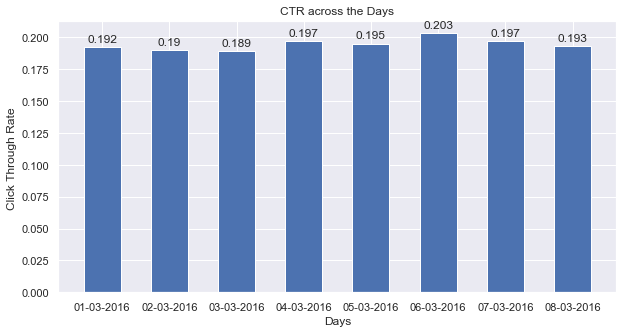

In [119]:
y=["01-03-2016","02-03-2016","03-03-2016","04-03-2016","05-03-2016","06-03-2016","07-03-2016","08-03-2016"]
width = 0.55
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(y,CTR_arr,width )
ax.set_ylabel('Click Through Rate ')
ax.set_title('CTR across the Days')
ax.set_xlabel('Days')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects);

#### CTR per Group per Day

In [120]:
CTR_01_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 1) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 1) & (data.group == 'a')]))
CTR_01_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 1) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 1) & (data.group == 'b')]))

CTR_02_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 2) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 2) & (data.group == 'a')]))
CTR_02_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 2) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 2) & (data.group == 'b')]))

CTR_03_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 3) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 3) & (data.group == 'a')]))
CTR_03_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 3) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 3) & (data.group == 'b')]))

CTR_04_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 4) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 4) & (data.group == 'a')]))
CTR_04_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 4) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 4) & (data.group == 'b')]))

CTR_05_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 5) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 5) & (data.group == 'a')]))
CTR_05_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 5) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 5) & (data.group == 'b')]))

CTR_06_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 6) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 6) & (data.group == 'a')]))
CTR_06_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 6) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 6) & (data.group == 'b')]))

CTR_07_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 7) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 7) & (data.group == 'a')]))
CTR_07_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 7) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 7) & (data.group == 'b')]))

CTR_08_A = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 8) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 8) & (data.group == 'a')]))
CTR_08_B = (len(data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.day == 8) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])))/(len(data[(data.action == 'searchResultPage') & (data.day == 8) & (data.group == 'b')]))

print("Day1: A = %s, B = %s" % (round(CTR_01_A*100,3),round(CTR_01_B*100,3)))
print("Day2: A = %s, B = %s" % (round(CTR_02_A*100,3),round(CTR_02_B*100,3)))
print("Day3: A = %s, B = %s" % (round(CTR_03_A*100,3),round(CTR_03_B*100,3)))
print("Day4: A = %s, B = %s" % (round(CTR_04_A*100,3),round(CTR_04_B*100,3)))
print("Day5: A = %s, B = %s" % (round(CTR_05_A*100,3),round(CTR_05_B*100,3)))
print("Day6: A = %s, B = %s" % (round(CTR_06_A*100,3),round(CTR_06_B*100,3)))
print("Day7: A = %s, B = %s" % (round(CTR_07_A*100,3),round(CTR_07_B*100,3)))
print("Day8: A = %s, B = %s" % (round(CTR_08_A*100,3),round(CTR_08_B*100,3)))

Day1: A = 22.453, B = 12.034
Day2: A = 21.765, B = 12.735
Day3: A = 21.416, B = 13.285
Day4: A = 21.014, B = 16.98
Day5: A = 20.483, B = 17.618
Day6: A = 22.325, B = 16.605
Day7: A = 20.852, B = 17.411
Day8: A = 20.858, B = 16.048


#### Plot: CTR per Group per Day

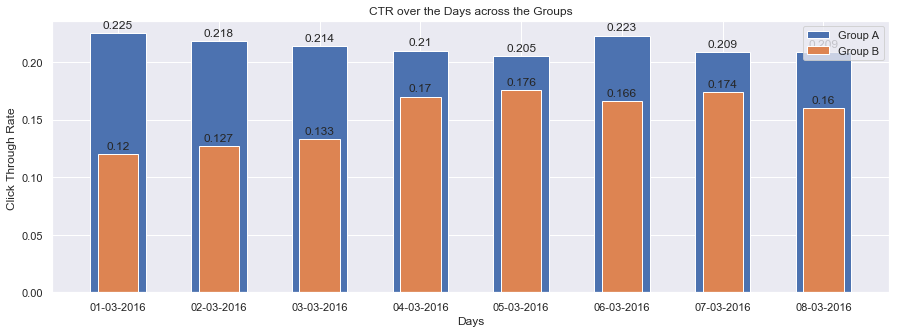

In [121]:
Group_CTR_per_day = pd.DataFrame([['01-03-2016', round(CTR_01_A,3), round(CTR_01_B,3)],['02-03-2016', round(CTR_02_A,3), round(CTR_02_B,3)],['03-03-2016', round(CTR_03_A,3), round(CTR_03_B,3)],
                                  ['04-03-2016', round(CTR_04_A,3), round(CTR_04_B,3)],['05-03-2016', round(CTR_05_A,3), round(CTR_05_B,3)],['06-03-2016', round(CTR_06_A,3), round(CTR_06_B,3)],
                                  ['07-03-2016', round(CTR_07_A,3), round(CTR_07_B,3)],['08-03-2016', round(CTR_08_A,3), round(CTR_08_B,3)]],
                                 columns=['Day', 'A', 'B'])
fig, ax = plt.subplots(figsize=(15, 5))
bar1 = ax.bar(Group_CTR_per_day['Day'],Group_CTR_per_day['A'], width, label='Group A')
bar2 = ax.bar(Group_CTR_per_day['Day'],Group_CTR_per_day['B'], width-0.15, label='Group B')

ax.set_ylabel('Click Through Rate ')
ax.set_title('CTR over the Days across the Groups')

ax.set_xlabel('Days')
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *bar1 and bar2*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(bar1)
autolabel(bar2);

# 2. Which results do people tend to try first? How does it change day-to-day?

#### Overall Results

In [122]:
Search_page_1st_Click = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))].groupby('session_id').mean().dropna(subset=['result_position'])
Search_page_1st_Click['Count'] = 1
Search_page_1st_Click = Search_page_1st_Click[['result_position','Count']]
Search_page_1st_Click['result_position'] = Search_page_1st_Click['result_position'].astype(int)
result_pos = Search_page_1st_Click.groupby('result_position').count()
result_pos = result_pos.sort_values(by=['Count'],ascending=False)
result_pos['Percentage'] = result_pos['Count']*100/26448 # len(Search_page_1st_Click) = 26448
result_pos.head(20)

,Count,Percentage
result_position,,
1,17307,65.437840
2,3798,14.360254
3,1907,7.210375
4,980,3.705384
5,602,2.276165
6,436,1.648518
7,307,1.160768
8,195,0.737296
9,155,0.586056


#### Plot: Frequency of Top10 Result Positions 

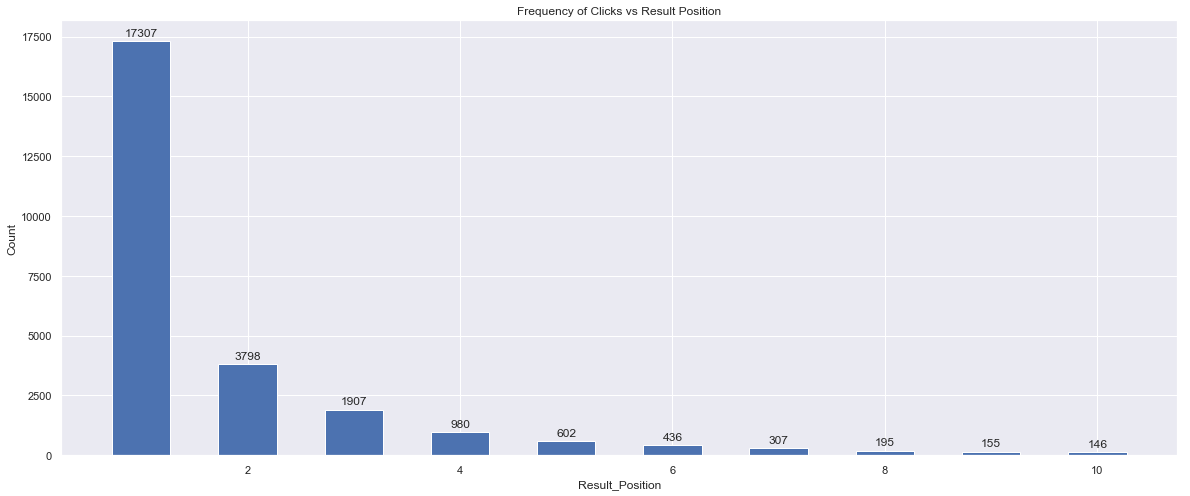

In [123]:
top_10 = result_pos[:10]

fig, ax = plt.subplots(figsize=(20, 8))
bar = ax.bar(top_10.index,top_10.Count, width)
ax.set_ylabel('Count')
ax.set_title('Frequency of Clicks vs Result Position')
ax.set_xlabel('Result_Position')

def autolabel(rects):
    """Attach a text label above each bar in *bar*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar);

### Trend of the two group of users

#### Group A

In [124]:
Search_page_1st_Click_A = data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.group == 'a')].groupby('session_id').mean().dropna(subset=['result_position'])
Search_page_1st_Click_A['Count'] = 1
Search_page_1st_Click_A = Search_page_1st_Click_A[['result_position','Count']]
Search_page_1st_Click_A['result_position'] = Search_page_1st_Click_A['result_position'].astype(int)
result_pos_A = Search_page_1st_Click_A.groupby('result_position').count()
result_pos_A = result_pos_A.sort_values(by=['Count'],ascending=False)
result_pos_A['Percentage'] = result_pos_A['Count']*100/19705 # len(Search_page_1st_Click_A) = 19705
result_pos_A.head(10)

,Count,Percentage
result_position,,
1,12759,64.750063
2,2847,14.448110
3,1421,7.211368
4,746,3.785841
5,460,2.334433
6,327,1.659477
7,250,1.268714
8,155,0.786602
9,126,0.639432


#### Plot: Frequency of Top10 Result Positions for Group A

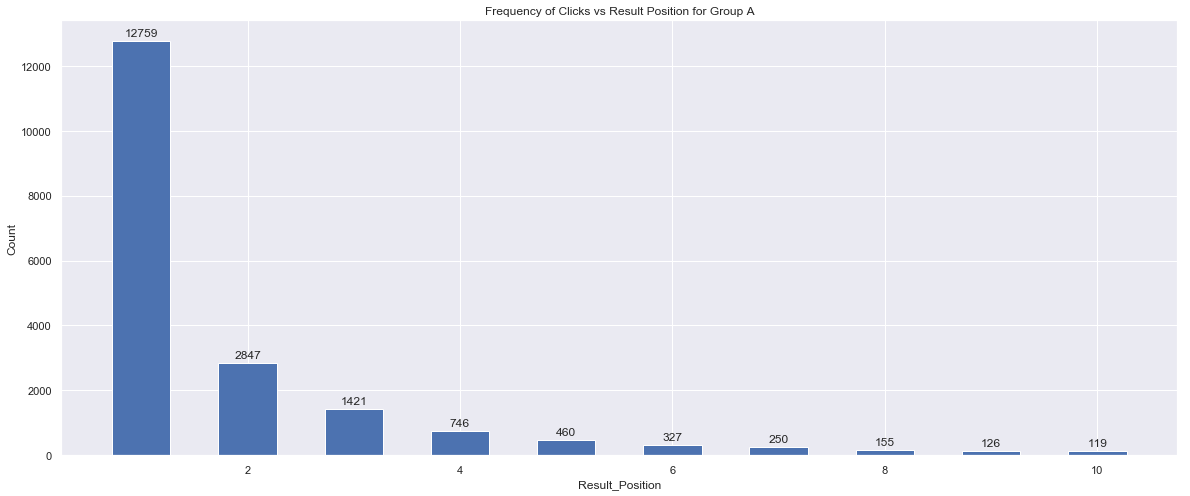

In [125]:
top_10_A = result_pos_A[:10]

fig, ax = plt.subplots(figsize=(20, 8))
bar = ax.bar(top_10_A.index,top_10_A.Count, width)
ax.set_ylabel('Count')
ax.set_title('Frequency of Clicks vs Result Position for Group A')
ax.set_xlabel('Result_Position')

def autolabel(rects):
    """Attach a text label above each bar in *bar*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar);

#### Group B

In [126]:
Search_page_1st_Click_B = data[((data.action == 'searchResultPage') | (data.action == 'visitPage')) & (data.group == 'b')].groupby('session_id').mean().dropna(subset=['result_position'])
Search_page_1st_Click_B['Count'] = 1
Search_page_1st_Click_B = Search_page_1st_Click_B[['result_position','Count']]
Search_page_1st_Click_B['result_position'] = Search_page_1st_Click_B['result_position'].astype(int)
result_pos_B = Search_page_1st_Click_B.groupby('result_position').count()
result_pos_B = result_pos_B.sort_values(by=['Count'],ascending=False)
result_pos_B['Percentage'] = result_pos_B['Count']*100/6743 # len(Search_page_1st_Click_B) = 6743
result_pos_B.head(10)

,Count,Percentage
result_position,,
1,4548,67.447724
2,951,14.103515
3,486,7.207474
4,234,3.470265
5,142,2.105888
6,109,1.616491
7,57,0.845321
8,40,0.593208
9,29,0.430076


#### Plot: Frequency of Top10 Result Positions for Group B

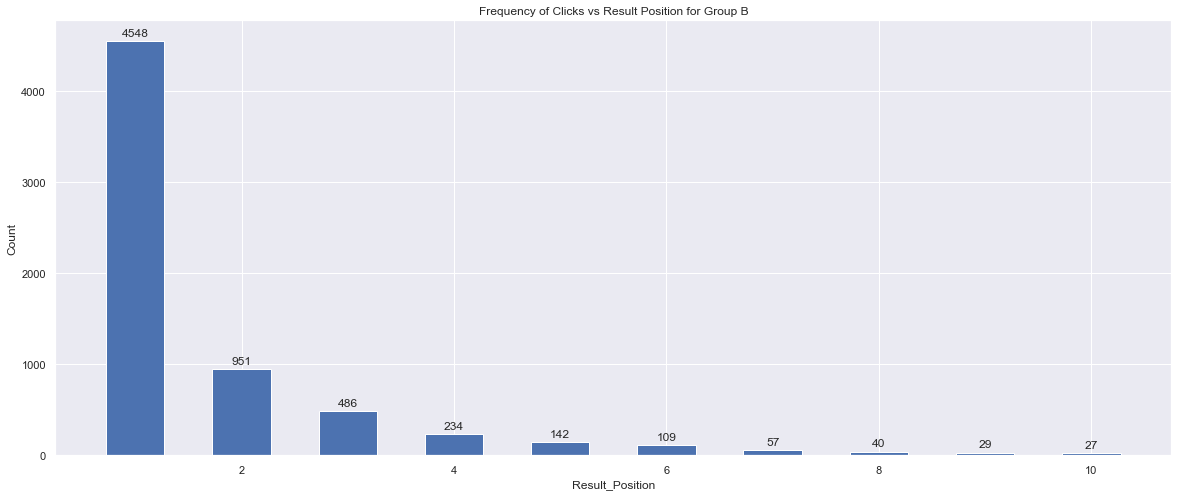

In [127]:
top_10_B = result_pos_B[:10]

fig, ax = plt.subplots(figsize=(20, 8))
bar = ax.bar(top_10_B.index,top_10_B.Count, width)
ax.set_ylabel('Count')
ax.set_title('Frequency of Clicks vs Result Position for Group B')
ax.set_xlabel('Result_Position')

def autolabel(rects):
    """Attach a text label above each bar in *bar*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar);

### Trend Observed on Each Day

#### Day1

In [128]:
Search_Day1 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 1)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day1['Count'] = 1
Search_Day1 = Search_Day1[['result_position','Count']]
Search_Day1['result_position'] = Search_Day1['result_position'].astype(int)
result_pos_Day1 = Search_Day1.groupby('result_position').count()
result_pos_Day1 = result_pos_Day1.sort_values(by=['Count'],ascending=False)
result_pos_Day1['Percentage'] = result_pos_Day1['Count']*100/3522 # len(Search_Day1) = 3522 
result_pos_Day1.head(10)

,Count,Percentage
result_position,,
1,2316,65.758092
2,542,15.388984
3,238,6.757524
4,122,3.463941
5,84,2.385009
6,44,1.249290
7,35,0.993754
9,22,0.624645
10,22,0.624645


#### Day2

In [129]:
Search_Day2 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 2)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day2['Count'] = 1
Search_Day2 = Search_Day2[['result_position','Count']]
Search_Day2['result_position'] = Search_Day2['result_position'].astype(int)
result_pos_Day2 = Search_Day2.groupby('result_position').count()
result_pos_Day2 = result_pos_Day2.sort_values(by=['Count'],ascending=False)
result_pos_Day2['Percentage'] = result_pos_Day2['Count']*100/3600 # len(Search_Day2) = 3600 
result_pos_Day2.head(10)

,Count,Percentage
result_position,,
1,2357,65.472222
2,497,13.805556
3,277,7.694444
4,147,4.083333
5,73,2.027778
6,65,1.805556
7,43,1.194444
8,31,0.861111
9,26,0.722222


#### Day3

In [130]:
Search_Day3 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 3)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day3['Count'] = 1
Search_Day3 = Search_Day3[['result_position','Count']]
Search_Day3['result_position'] = Search_Day3['result_position'].astype(int)
result_pos_Day3 = Search_Day3.groupby('result_position').count()
result_pos_Day3 = result_pos_Day3.sort_values(by=['Count'],ascending=False)
result_pos_Day3['Percentage'] = result_pos_Day3['Count']*100/3625 # len(Search_Day3) = 3625 
result_pos_Day3.head(10)

,Count,Percentage
result_position,,
1,2392,65.986207
2,493,13.600000
3,257,7.089655
4,126,3.475862
5,87,2.400000
6,62,1.710345
7,47,1.296552
10,26,0.717241
8,26,0.717241


#### Day4

In [131]:
Search_Day4 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 4)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day4['Count'] = 1
Search_Day4 = Search_Day4[['result_position','Count']]
Search_Day4['result_position'] = Search_Day4['result_position'].astype(int)
result_pos_Day4 = Search_Day4.groupby('result_position').count()
result_pos_Day4 = result_pos_Day4.sort_values(by=['Count'],ascending=False)
result_pos_Day4['Percentage'] = result_pos_Day4['Count']*100/3287 # len(Search_Day4) = 3287 
result_pos_Day4.head(10)

,Count,Percentage
result_position,,
1,2190,66.626103
2,477,14.511713
3,216,6.571342
4,120,3.650745
5,67,2.038333
6,60,1.825373
7,32,0.973532
8,25,0.760572
9,15,0.456343


#### Day5

In [132]:
Search_Day5 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 5)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day5['Count'] = 1
Search_Day5 = Search_Day5[['result_position','Count']]
Search_Day5['result_position'] = Search_Day5['result_position'].astype(int)
result_pos_Day5 = Search_Day5.groupby('result_position').count()
result_pos_Day5 = result_pos_Day5.sort_values(by=['Count'],ascending=False)
result_pos_Day5['Percentage'] = result_pos_Day5['Count']*100/2573 # len(Search_Day5) = 2573
result_pos_Day5.head(10)

,Count,Percentage
result_position,,
1,1662,64.593859
2,402,15.623785
3,185,7.190051
4,93,3.614458
5,65,2.526234
7,30,1.165954
6,26,1.010494
8,20,0.777303
10,19,0.738438


#### Day6

In [133]:
Search_Day6 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 6)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day6['Count'] = 1
Search_Day6 = Search_Day6[['result_position','Count']]
Search_Day6['result_position'] = Search_Day6['result_position'].astype(int)
result_pos_Day6 = Search_Day6.groupby('result_position').count()
result_pos_Day6 = result_pos_Day6.sort_values(by=['Count'],ascending=False)
result_pos_Day6['Percentage'] = result_pos_Day6['Count']*100/2968 # len(Search_Day6) = 2968
result_pos_Day6.head(10)

,Count,Percentage
result_position,,
1,1929,64.993261
2,424,14.285714
3,224,7.547170
4,116,3.908356
5,64,2.156334
6,54,1.819407
7,29,0.977089
8,21,0.707547
10,20,0.673854


#### Day7

In [134]:
Search_Day7 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 7)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day7['Count'] = 1
Search_Day7 = Search_Day7[['result_position','Count']]
Search_Day7['result_position'] = Search_Day7['result_position'].astype(int)
result_pos_Day7 = Search_Day7.groupby('result_position').count()
result_pos_Day7 = result_pos_Day7.sort_values(by=['Count'],ascending=False)
result_pos_Day7['Percentage'] = result_pos_Day7['Count']*100/3747 # len(Search_Day7) = 3747
result_pos_Day7.head(10)

,Count,Percentage
result_position,,
1,2418,64.531625
2,530,14.144649
3,278,7.419269
4,150,4.003203
5,89,2.375234
6,61,1.627969
7,52,1.387777
8,28,0.747264
10,21,0.560448


#### Day8

In [135]:
Search_Day8 = data[((data.action == 'searchResultPage') | (data.action == 'visitPage'))& (data.day == 8)].groupby('session_id').mean().dropna(subset=['result_position'])
Search_Day8['Count'] = 1
Search_Day8 = Search_Day8[['result_position','Count']]
Search_Day8['result_position'] = Search_Day8['result_position'].astype(int)
result_pos_Day8 = Search_Day8.groupby('result_position').count()
result_pos_Day8 = result_pos_Day8.sort_values(by=['Count'],ascending=False)
result_pos_Day8['Percentage'] = result_pos_Day8['Count']*100/3140 # len(Search_Day8) = 3140
result_pos_Day8.head(10)

,Count,Percentage
result_position,,
1,2052,65.350318
2,435,13.853503
3,232,7.388535
4,107,3.407643
5,73,2.324841
6,64,2.038217
7,40,1.273885
8,25,0.796178
11,17,0.541401


#### Plot: Frequency of Top10 Result Positions across all Days

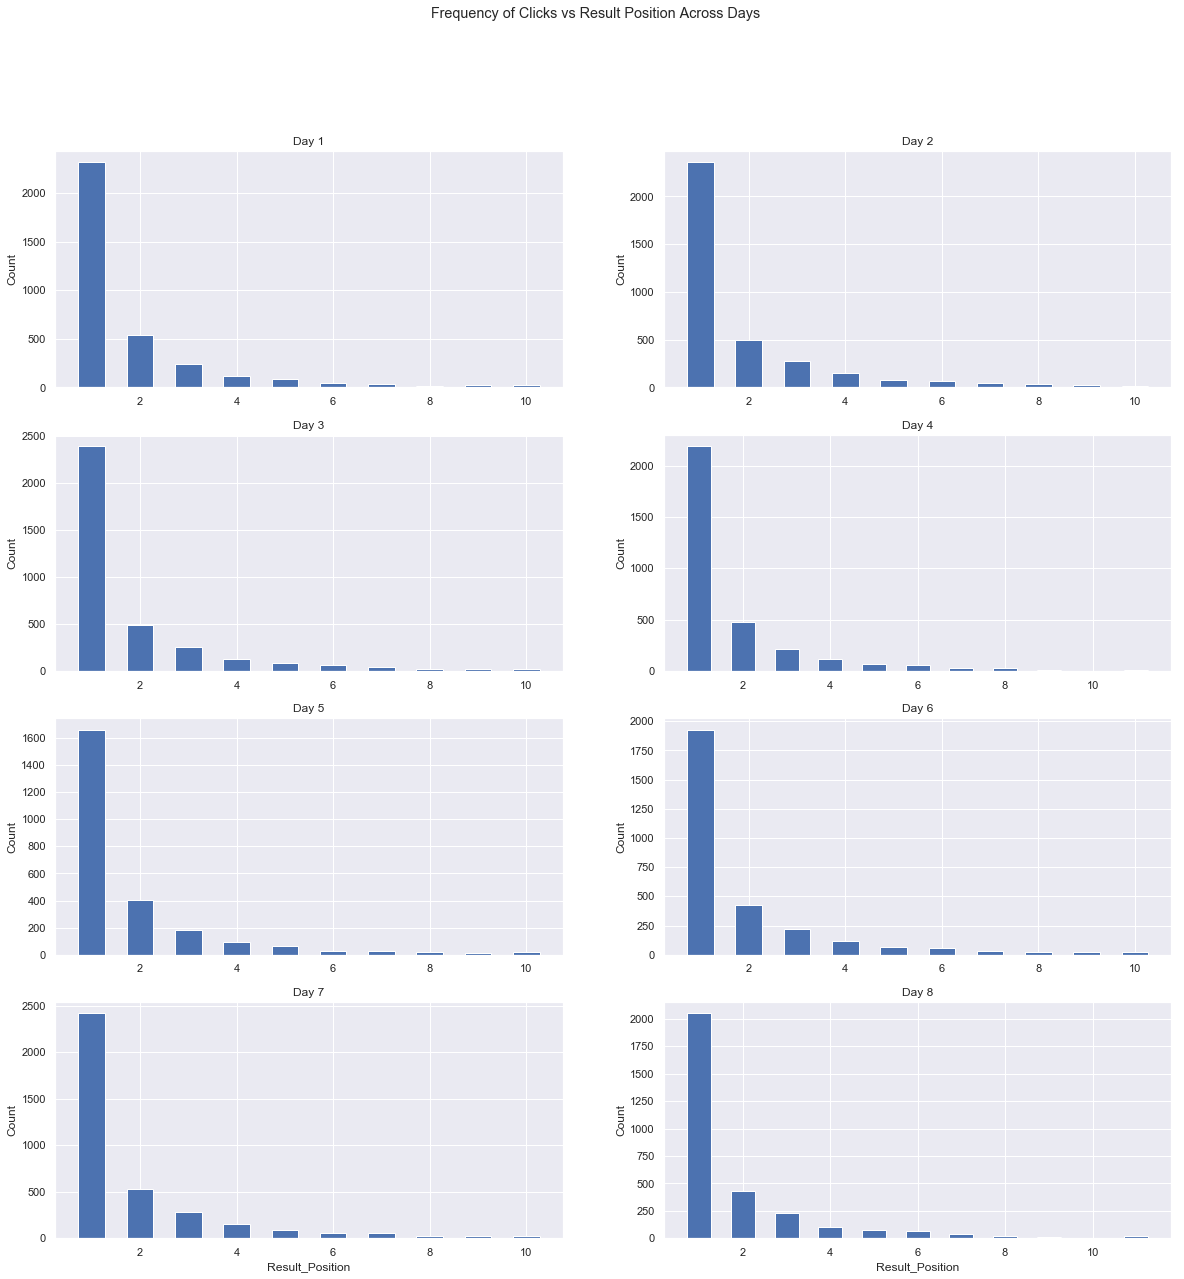

In [136]:
top_10_D1 = result_pos_Day1[:10]
top_10_D2 = result_pos_Day2[:10]
top_10_D3 = result_pos_Day3[:10]
top_10_D4 = result_pos_Day4[:10]
top_10_D5 = result_pos_Day5[:10]
top_10_D6 = result_pos_Day6[:10]
top_10_D7 = result_pos_Day7[:10]
top_10_D8 = result_pos_Day8[:10]

fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize=(20, 20))

bar1 = ax[0][0].bar(top_10_D1.index,top_10_D1.Count, width)
bar2 = ax[0][1].bar(top_10_D2.index,top_10_D2.Count, width)
bar3 = ax[1][0].bar(top_10_D3.index,top_10_D3.Count, width)
bar4 = ax[1][1].bar(top_10_D4.index,top_10_D4.Count, width)
bar5 = ax[2][0].bar(top_10_D5.index,top_10_D5.Count, width)
bar6 = ax[2][1].bar(top_10_D6.index,top_10_D6.Count, width)
bar7 = ax[3][0].bar(top_10_D7.index,top_10_D7.Count, width)
bar8 = ax[3][1].bar(top_10_D8.index,top_10_D8.Count, width)
ax[0][0].set_ylabel('Count')
ax[0][1].set_ylabel('Count')
ax[1][0].set_ylabel('Count')
ax[1][1].set_ylabel('Count')
ax[2][0].set_ylabel('Count')
ax[2][1].set_ylabel('Count')
ax[3][0].set_ylabel('Count')
ax[3][1].set_ylabel('Count')
ax[3][0].set_xlabel('Result_Position')
ax[3][1].set_xlabel('Result_Position')
ax[0][0].set_title("Day 1")
ax[0][1].set_title("Day 2")
ax[1][0].set_title("Day 3")
ax[1][1].set_title("Day 4")
ax[2][0].set_title("Day 5")
ax[2][1].set_title("Day 6")
ax[3][0].set_title("Day 7")
ax[3][1].set_title("Day 8")
fig.suptitle("Frequency of Clicks vs Result Position Across Days");

# 3. What is the daily overall zero results rate? How does it vary between the groups?

#### Overall Zero Results Rate

In [137]:
#Day 01
ZRR_01 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 1)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 1)]))
#Day 02
ZRR_02 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 2)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 2)]))
#Day 03
ZRR_03 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 3)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 3)]))
#Day 04
ZRR_04 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 4)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 4)]))
#Day 05
ZRR_05 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 5)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 5)]))
#Day 06
ZRR_06 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 6)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 6)]))
#Day 07
ZRR_07 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 7)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 7)]))
#Day 08
ZRR_08 = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.day == 8)]))/(len(data[(data.action == 'searchResultPage') & (data.day == 8)]))

ZRR_arr = [round(ZRR_01,3),round(ZRR_02,3),round(ZRR_03,3),round(ZRR_04,3),round(ZRR_05,3),round(ZRR_06,3),round(ZRR_07,3),round(ZRR_08,3)]
ZRR_daily = np.average(ZRR_arr)

print("The Overall Zero Results Rate is %s" % ZRR_daily)

The Overall Zero Results Rate is 0.1845


#### Plot: ZRR across all the days

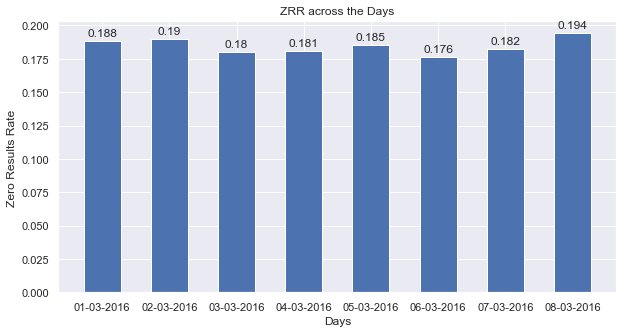

In [138]:
y=["01-03-2016","02-03-2016","03-03-2016","04-03-2016","05-03-2016","06-03-2016","07-03-2016","08-03-2016"]
width = 0.55
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(y,ZRR_arr,width)
ax.set_ylabel('Zero Results Rate ')
ax.set_title('ZRR across the Days')
ax.set_xlabel('Days')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects);

#### Zero Rate Results Between the two Groups

In [139]:
ZRR_A = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.group == 'a')]))/(len(data[data.action == 'searchResultPage']))

ZRR_B = (len(data[(data.action == 'searchResultPage') & (data.n_results == 0) & (data.group == 'b')]))/(len(data[data.action == 'searchResultPage']))

print("Zero Results Rate for Group A Overall is %s" % round(ZRR_A*100,3))
print("Zero Results Rate for Group B Overall is %s" % round(ZRR_B*100,3))
print("Percentage of ZRR for Group A is %s" % round((ZRR_A/ZRR_daily)*100,3))
print("Percentage of ZRR for Group B is %s" % round((ZRR_B/ZRR_daily)*100,3))

Zero Results Rate for Group A Overall is 12.407
Zero Results Rate for Group B Overall is 6.037
Percentage of ZRR for Group A is 67.245
Percentage of ZRR for Group B is 32.723


# 4. Let *session length* be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

Looking at the dataframe *data*, we see there can be two ways to estimate session length - 1._timestamp_ & 2._checkin_
But before that, we have to define our first and last events. If a user searches for a page and remains there/refreshes 
the same page continuosly for x hours, that user doesn't add value to our product (in this case the website). Thus,
tracking should start as soon as the user clicks on a link on the visitPage. So, our __First event__ should be visitPage & 
__Last event__ should be the last checkin. 
Like mentioned before, we can calculate approximate time between the two events by taking the timestamp difference of them
respectively from the _timestamp_ column.
But, to make it easier, we already have __checkin__ feature. For a particular session (*session_id*), we can check the last event and 
get the corresponding checkin value as the approximate sessions length. For NaN values, session length is 0.


#### Session Length as a Dataframe for all Sessions

In [140]:
session_length_df = data[['session_id','action','timestamp','checkin']].sort_values('timestamp').groupby('session_id').apply(lambda x: x.set_index('session_id').rename_axis('Index',axis = 1))
session_length_df.head(25)

Index                                        action           timestamp  \
session_id       session_id                                               
0000cbcb67c19c45 0000cbcb67c19c45  searchResultPage 2016-03-03 15:20:45   
0001382e027b2ea4 0001382e027b2ea4  searchResultPage 2016-03-07 08:49:55   
                 0001382e027b2ea4         visitPage 2016-03-07 08:49:58   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:08   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:18   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:28   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:38   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:48   
                 0001382e027b2ea4           checkin 2016-03-07 08:50:58   
                 0001382e027b2ea4           checkin 2016-03-07 08:51:28   
                 0001382e027b2ea4           checkin 2016-03-07 08:51:58   
                 0001382e027b2ea4           checkin 2016-03-07 08:52:28   
                 0001382e027b2ea4           checkin 2016-03-07 08:52:58   
                 0001382e027b2ea4           checkin 2016-03-07 08:53:28   
                 0001382e027b2ea4           checkin 2016-03-07 08:53:58   
                 0001382e027b2ea4           checkin 2016-03-07 08:54:58   
0001e8bb90445cb2 0001e8bb90445cb2  searchResultPage 2016-03-05 09:24:15   
                 0001e8bb90445cb2         visitPage 2016-03-05 09:24:30   
                 0001e8bb90445cb2           checkin 2016-03-05 09:24:40   
                 0001e8bb90445cb2           checkin 2016-03-05 09:24:50   
                 0001e8bb90445cb2           checkin 2016-03-05 09:25:00   
                 0001e8bb90445cb2           checkin 2016-03-05 09:25:10   
                 0001e8bb90445cb2           checkin 2016-03-05 09:25:20   
                 0001e8bb90445cb2           checkin 2016-03-05 09:25:30   
                 0001e8bb90445cb2           checkin 2016-03-05 09:26:00   

Index                              checkin  
session_id       session_id                 
0000cbcb67c19c45 0000cbcb67c19c45      NaN  
0001382e027b2ea4 0001382e027b2ea4      NaN  
                 0001382e027b2ea4      NaN  
                 0001382e027b2ea4     10.0  
                 0001382e027b2ea4     20.0  
                 0001382e027b2ea4     30.0  
                 0001382e027b2ea4     40.0  
                 0001382e027b2ea4     50.0  
                 0001382e027b2ea4     60.0  
                 0001382e027b2ea4     90.0  
                 0001382e027b2ea4    120.0  
                 0001382e027b2ea4    150.0  
                 0001382e027b2ea4    180.0  
                 0001382e027b2ea4    210.0  
                 0001382e027b2ea4    240.0  
                 0001382e027b2ea4    300.0  
0001e8bb90445cb2 0001e8bb90445cb2      NaN  
                 0001e8bb90445cb2      NaN  
                 0001e8bb90445cb2     10.0  
                 0001e8bb90445cb2     20.0  
                 0001e8bb90445cb2     30.0  
                 0001e8bb90445cb2     40.0  
                 0001e8bb90445cb2     50.0  
                 0001e8bb90445cb2     60.0  
                 0001e8bb90445cb2     90.0

# 5. Summarize your findings in an *executive summary*.

The Dataset that was provided was clean and didnot require much preprocessing. 
The Dataset consisted of events logged between _01-03-2016_ and _08-03-2016_. 


For tracking purpose and better understand user behaviour, A/B testing was implemented. Thus, the users were divided into two
groups: *A* & _B_.

Tracking was done right from when a new search is performed and the user is shown a SERP to user clicking a link in the results and then remaining on the page for a pre-specified amount of time.

The _Daily Overall Click Through Rate_ was estimated to be 19.45%. 
The CTR across the eight days was fairly similar, without much difference. On 06-03-2016, CTR was found to be more than 20%.
CTR varied greatly between the two groups. For Group A, we saw CTR to be fairly consistent and above 20% on all days. The highest being 22.4% on 01-03-2016. For Group B, we saw CTR was less than 15% for the first three days. But it showed an increasing trend and in the next five days, we found the CTR to be above 15%. For Group B, the highest CTR was achieved on 05-03-2016 and it was found to be 17.6%. Despite Group B showing an increasing trend, Group A's CTR was more on all days.

While analyzing which links users usually click, we found 65% users clicked on the 1st link with the next highest being the 2nd link with 14%. The rate of clicks drastically decreases as the result position increases. Thus, Frequency of Clicks is _inversely proportional_ to the result position. 
We can see the same trend across all the days individually as well as for both the groups. 67% of Group A users preferred 1st link where as 64% of Group B preferred the 1st link
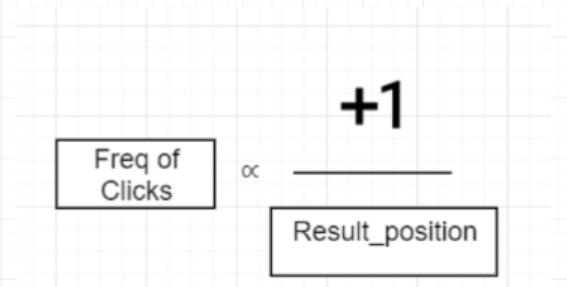


The _Overall Daily Zero Rate Results_ was found to be 18.4%. It was more or less the same across all the days.Group A accounted for 67.3% of the ZRR and Group B the rest 32.7%.

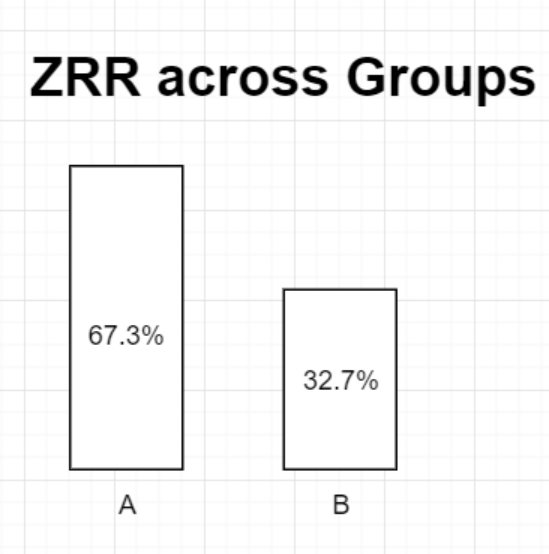


The Session Length is visualized as per the below diagram:

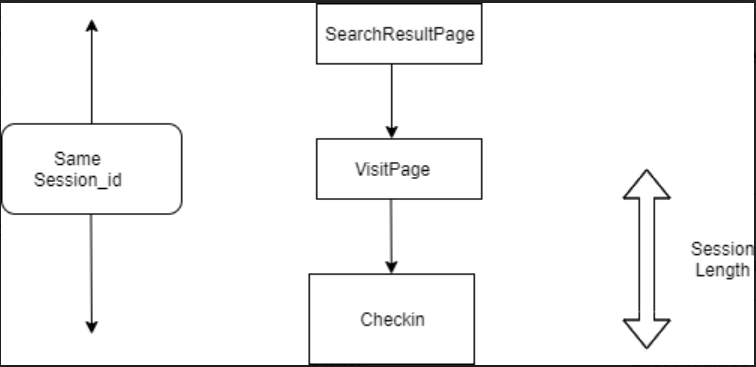
